In [61]:
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm
import string
import pytesseract
from PIL import Image


In [62]:
PATH = '../dataset/Date-Real/images/'

In [63]:
ANNOTATIONS_PATH = '../dataset/Date-Real//annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

Loading images: 100%|██████████| 510/510 [00:00<00:00, 1312.69it/s]


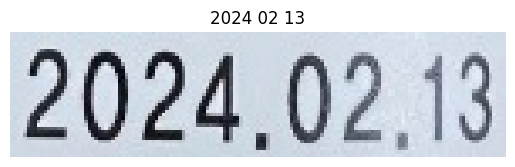

In [64]:
# Load dataset

X = []
Y = []


for idx, file in enumerate(tqdm(os.listdir(PATH), desc="Loading images")):

    file_path = os.path.join(PATH, file)

    image = Image.open(file_path)

    label = get_y_from_json(file)

    if label != " ":
        X.append(image)
        Y.append(label)

    
plt.imshow(X[100], cmap='gray')
plt.title(Y[100])
plt.axis('off')
plt.show()

In [65]:
def preprocess_image(image):
    image_cv = cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)

    image_cv = cv.resize(image_cv, (0, 0), fx=2, fy=2)  

    denoised = cv.fastNlMeansDenoisingColored(image_cv, None, 10, 10, 7, 21)

    gray = cv.cvtColor(denoised, cv.COLOR_BGR2GRAY)

    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))

    closed = cv.morphologyEx(binary, cv.MORPH_CLOSE, kernel, iterations=1)

    return closed

from datetime import datetime

def format_to_datestring(date_str):
    date_formats = [
        "%Y %m %d",    
        "%d %m %Y",   
        "%m/%d/%Y",
        "%d/%m/%Y", 
        "%Y-%m-%d",
        "%d-%m-%Y",
    ]
    
    for date_format in date_formats:
        try:
            date_obj = datetime.strptime(date_str, date_format)
            formatted_date = date_obj.strftime("%d %B %Y")
            return formatted_date
        except ValueError:
            continue
    
    return date_str

In [66]:
def character_accuracy(pred_text, truth_text):
    correct_chars = sum([1 for p, t in zip(pred_text, truth_text) if p == t])
    return correct_chars / len(truth_text) if len(truth_text) > 0 else 0.0

def exact_match_accuracy(pred_text, truth_text):
    return 1 if pred_text == truth_text else 0

def manual_evaluate(Y_pred, Y_test):
    correct_char_count = 0
    exact_match_count = 0
    total_samples = len(Y_pred) 

    for idx in range(total_samples):
        pred_text = Y_pred[idx]
        truth_text = Y_test[idx]

        char_acc = character_accuracy(pred_text, truth_text)
        exact_acc = exact_match_accuracy(pred_text, truth_text)
        
        correct_char_count += char_acc
        exact_match_count += exact_acc

    avg_char_accuracy = correct_char_count / total_samples
    avg_exact_accuracy = exact_match_count / total_samples

    print(f"Samples: {total_samples} | Correct: {exact_match_count}")
    print(f"Average character-level accuracy: {avg_char_accuracy:.4f}")
    print(f"Average exact match accuracy: {avg_exact_accuracy:.4f}")
    
    return avg_char_accuracy, avg_exact_accuracy

In [67]:
import re
from tqdm import tqdm
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

# Perform OCR and calculate accuracy
correct_predictions = 0
total_images = len(X)

ocr_results = []

def clean_text(text):
    return re.sub(r'[^0-9]', ' ', text).strip()

for idx in tqdm(range(total_images), desc="Performing OCR"):
    
    preprocessed_image = preprocess_image(X[idx])

    extracted_text = pytesseract.image_to_string(preprocessed_image, config='--psm 6')

    output = clean_text(extracted_text)

    ocr_results.append(output)

    if output == clean_text(Y[idx]):
        correct_predictions += 1

# Calculate accuracy
# accuracy = (correct_predictions / total_images) * 100

avg_char_accuracy, avg_exact_accuracy = manual_evaluate(ocr_results, Y)

# print(f"Total Images: {total_images}")
# print(f"Correct Predictions: {correct_predictions}")
# print(f"Accuracy: {accuracy:.2f}%")



Performing OCR: 100%|██████████| 510/510 [03:02<00:00,  2.80it/s]

Samples: 510 | Correct: 247
Average character-level accuracy: 0.6321
Average exact match accuracy: 0.4843


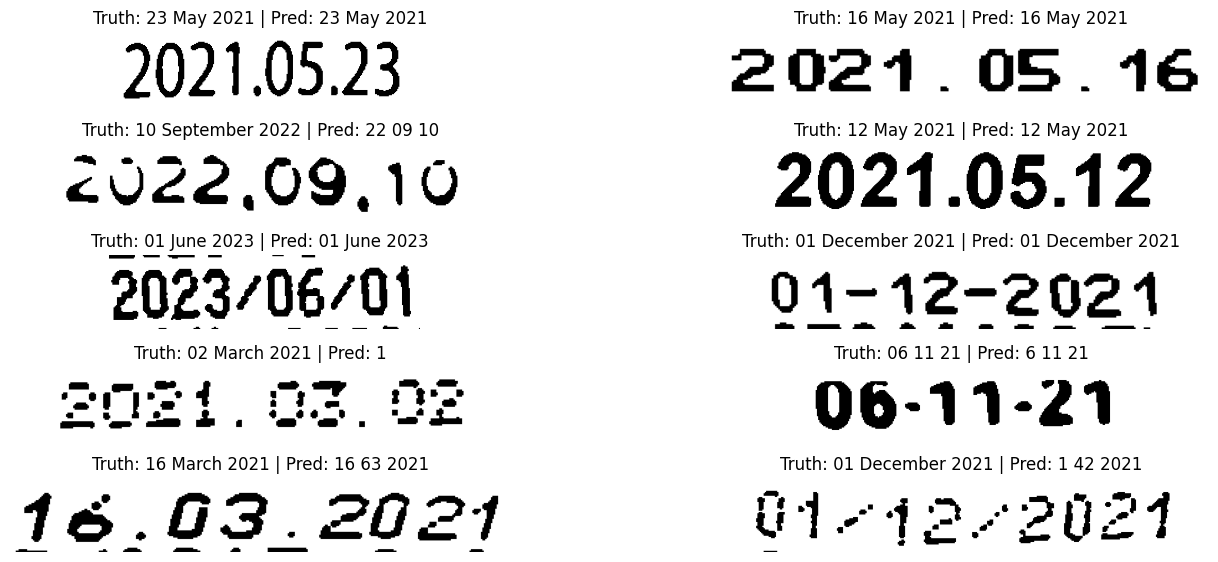

In [68]:
n_sample = 10

plt.figure(figsize=(16, 14))
for idx in range(n_sample): 
    
    plt.subplot(n_sample, 2, idx + 1)
    plt.imshow(preprocess_image(X[idx]), cmap='gray')
    plt.title(f"Truth: {format_to_datestring(Y[idx])} | Pred: {format_to_datestring(ocr_results[idx])}")
    plt.axis('off')
    
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [69]:
X[0].shape

AttributeError: 'JpegImageFile' object has no attribute 'shape'